# Read example thermometer data files from Jason Smith

Files are
```
./603_05Sep22.log
./604_05Sep22.log
./605_05Sep22.log
```

Parses data lines as regular expressions, and date stamps as DateTimes.

Jupyter IJulia notebook written in Julia; run in Julia 1.8.1.

In [1]:
using Dates

using PyPlot
ENV[ "MPLBACKEND" ] = "qt5agg"

using Interpolations
using MAT
using CSV
#using NetCDF

In [2]:
# parameters
datapath = "../data/raw/20220905/"

"../data/raw/20220905/"

In [3]:
"Read and parse lines from Jason Smith's .log data file with time stamps."
function get_data(
        filename, 
        nheaderlines=7, nfooterlines=11,
        data_ex = Regex( "^\\[([0-9]{2}:[0-9]{2}:[0-9.]{6})\\]"
                *" ([0-9]{1,}),"
                *" ([0-9.]{1,})\$"),
        df=DateFormat("HH:MM:SS.sss")
    )
    
    nlines = countlines( filename ) # count input lines in file
    ndata = nlines - nheaderlines - nfooterlines # ideal max data length
    
    # initialize arrays
    dtime = Array{DateTime, 1}( undef, ndata )
    msec = Array{Int64, 1}( undef, ndata )
    temp = Array{Float32, 1}( undef, ndata )
    
    i = 0 #counter of lines skipped or read
    idata = 0 #number of data lines read
    
    open( filename, "r" ) do a
        while i < nheaderlines
            i += 1
            readline(a)
        end
        while idata < ndata
            i += 1
            l = readline(a)
            # parse 1 line
            m = match( data_ex, l )
            if !isnothing(m)
                idata += 1
                dtime[idata] = DateTime( m[:1], df )
                msec[idata] = parse( Int64, m[:2] )
                temp[idata] = parse( Float32, m[:3] )
            end
        end
    end
    
    return dtime, msec, temp
end

dt2min(dt) = (dt-dt[1])./Minute(1.) # convert time to number in minutes

dt2min (generic function with 1 method)

In [4]:
# load Rotronics data from file
rot_df = Dict( "Date" => dateformat"m/d/y", "Time" => dateformat"I:M:S p" )
rot = CSV.File( joinpath(datapath, "rot_0020568591_20220905_114308.csv"),
                header=41,
                skipto=45,
                drop=[5,],
                dateformat=rot_df )

1297-element CSV.File:
 CSV.Row: (Date = Date("2022-09-05"), Time = Time(11, 43, 30), Humidity = 70.44, Temperature = 24.3)
 CSV.Row: (Date = Date("2022-09-05"), Time = Time(11, 43, 45), Humidity = 71.56, Temperature = 24.33)
 CSV.Row: (Date = Date("2022-09-05"), Time = Time(11, 44), Humidity = 70.58, Temperature = 24.34)
 CSV.Row: (Date = Date("2022-09-05"), Time = Time(11, 44, 15), Humidity = 70.06, Temperature = 24.37)
 CSV.Row: (Date = Date("2022-09-05"), Time = Time(11, 44, 30), Humidity = 69.36, Temperature = 24.38)
 CSV.Row: (Date = Date("2022-09-05"), Time = Time(11, 44, 45), Humidity = 69.57, Temperature = 24.39)
 CSV.Row: (Date = Date("2022-09-05"), Time = Time(11, 45), Humidity = 68.78, Temperature = 24.4)
 CSV.Row: (Date = Date("2022-09-05"), Time = Time(11, 45, 15), Humidity = 68.78, Temperature = 24.4)
 CSV.Row: (Date = Date("2022-09-05"), Time = Time(11, 45, 30), Humidity = 69.33, Temperature = 24.41)
 CSV.Row: (Date = Date("2022-09-05"), Time = Time(11, 45, 45), Humidit

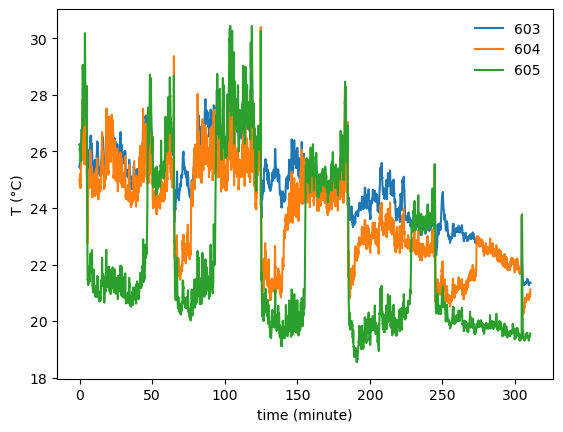

PyObject <matplotlib.legend.Legend object at 0x7fa271feff10>

In [5]:
# load RBR temperature sensor data and plot on one axis

filenames = joinpath.( datapath, 
                ["603_05Sep22.log", "604_05Sep22.log", "605_05Sep22.log"] )

dtime603, msec, t603 = get_data( filenames[1] )
plot( dt2min(dtime603), t603 )

dtime604, msec, t604 = get_data( filenames[2] )
plot( dt2min(dtime604), t604 )

dtime605, msec, t605 = get_data( filenames[3] )
plot( dt2min(dtime605), t605 )

ylabel("T (°C)")
xlabel("time (minute)")
legend(["603", "604", "605"]; frameon=false)

Jason needs to confirm:
```
603 fat temp probe,
604 skinny probe with no stainless mesh
605 skinny probe with stainless mesh
```


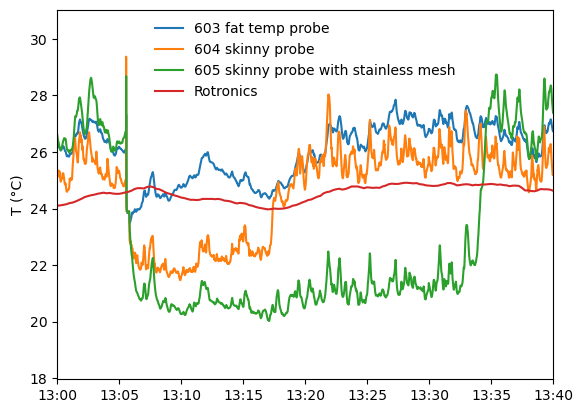

PyObject <matplotlib.legend.Legend object at 0x7fa250900910>

In [6]:
ax = subplot(1,1,1)

plot( dtime603, t603 )
plot( dtime604, t604 )
plot( dtime605, t605 )
plot( Date(1,1,1) .+ rot.Time, rot.Temperature )
ylabel("T (°C)")

# xlim([DateTime(1,1,1,13,0,0), DateTime(1,1,1,1,17,0,0)])
xlim([DateTime(1,1,1,13,0,0), DateTime(1,1,1,13,40,0)])
X = ax.xaxis
mdates = PyPlot.matplotlib.dates
#X.set_major_locator(mdates.MinuteLocator(45))
X.set_major_formatter(mdates.DateFormatter("%H:%M")) # Specify the format - %b gives us Jan, Feb...
legend(["603 fat temp probe", "604 skinny probe", "605 skinny probe with stainless mesh", "Rotronics"]; frameon=false)

Little cooling observed of 603.

Mesh on 605 keeps it wet and cool ~30 min, about ~2x as long as 604.

Skinny bare 604 is cooler than other 2 probes when dry. Perhaps it's subject to less radiative warming.

Take troughs as the ventilated times when we approach the T and Twet (e.g. between  13:20-13:35)


In [7]:
#Take troughs 13:20-13:35 as the ventilated times when we approach the T and Twet.
# 604 T, 605 Twet

# Psychrometry

In [8]:
# constants
Cp = 1005

Cpv = 1870.0 # J/kg/K
Cw  = 4190.0
L0 = 2.501e6 # J/kg

Rd = 287.04
Rv = 461.5
RdoRv=Rd/Rv

"latent heat of water vapor"
LvK(TempK) = 2.501e6 + (Cpv-Cw) * (TempK-273.0)

"""
es(T,p) = is saturation vapor pressure based on Wexler's formula,
with enhancement factor for moist air rather than water vapor.
The enhancement factor requires a pressure.
T [degrees C], p [Pa] (note the reversed input order), es [Pa]
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
function es(T,p=1e5,forceC=false)
    
P = p*1e-2 # P in hPa
if ( !forceC && T>200.0 )
    @info "Temperature $T in Kelvin detected."
    T = T - 273.15
end
esat = 1e2 * 6.1121*(1.0007 + 3.46e-8*P)*exp((17.502*T)/(240.97 + T)) # convert es to Pa
end

"""
qs(p,T) is saturation specific humidity based on Wexler's formula for es
with enhancement factor (see es.m).
p [Pa], T [degrees C], qs [kg/kg]
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
function qs(p,T)
esat = es(T,p)
qsat = RdoRv*esat / (p + (RdoRv-1)*esat)  
end

"""
dqsdT = d(qs(p, Temp))/d(Temp) = qs(p,Temp)*Lv(Temp)/(Rv*Temp**2)  [K^{-1}]
using Wexler and Clausius-Clapeyron formulas
p[Pa], T[degrees C]
  
273, 273.15 shifts in Temp are deliberate, to offset other
inconsistencies in the thermo functions. SPdeS 01.July.2005
"""
dqsdT(p,Temp) = qs(p,Temp)*LvK(Temp+273)/(Rv*(Temp+273.15)^2)

"""
Tw=Twet(Tdry[C], qv[kg/kg], p[Pa])
Computes the wet bulb temperature from an isobaric process
by using heat internal energy -Cp*dT=L*dq to evaporate
and raise qv to qs(Twb).
Simon de Szoeke 2016-04-07
"""
function Twet(Tdry,qv,p,niter=5)

# initialize Tw, qw
Tw = Tdry # problem for temperatures greater than 100 C!
qs0 = qs(p,Tw)
qw = min(qs0, qv)

Lvap = 2.501e6 + (Cpv-Cw) * Tw
stepfac = Cp/(Lvap*dqsdT(p, Tw)) # ~0.3

# Steps by 1/4 of saturation deficit and enforces -Cp*dT=L*dq by successive approximations
for iter = 1 : niter
    dq = stepfac * (qs(p,Tw) - qw)
    if dq<0; break; end
    Lvap = 2.501e6 + (Cpv-Cw) * Tw
    dT=-Lvap/Cp*dq
    qw=qw+dq
    Tw=Tw+dT
end
        
return Tw      
end

"""
    q = q_psychro(T[C], Tw[C], p[Pa])
    returns specific humidity from dry-bulb T and wet-bulb Tw.
    Simon de Szoeke 2020-01-31
"""
function q_psychro(T, Tw, p=101300.0, salfac=1.0)
# cd /Volumes/GoogleDrive/'My Drive'/Proposals/NSF_Oce2020/experiments/

# integrate without approximating Lv
# qw = 0.98*qs(p, Tw); # saturation specific humidity over the wet bulb
qw = salfac*qs(p, Tw); # saturation specific humidity over the wet bulb
dq = -Cp/(Cpv-Cw) * log( (L0 + (Cpv-Cw)*Tw) / (L0 + (Cpv-Cw)*T) );
q = qw - dq;
    
# # compute Lv(Tw)
# Lv = L0 + (Cpv-Cw) * Tw
# q = qw + Cp/Lv * (Tw - T)

# %q-q0 = about -1e-8 kg/kg, insignificant. Approximation is sufficient
return q
end

q_psychro

In [9]:
# time interpolations

uniqueidx(v) = unique(i -> v[i], eachindex(v))

"return interpolator to map T(x) at knots x to T(y) at y"
function interpx2y(x::Vector, T::Vector)
    ui = uniqueidx(x)
    itp = LinearInterpolation(x[ui], T[ui])
end

dv(x::DateTime) = Dates.value(x)
itp_to_605(dt, T) = interpx2y(dv.(dt), T)(dv.(dtime605))

t603_605 = itp_to_605(dtime603, t603)
t604_605 = itp_to_605(dtime604, t604)

# test fcns w/ imperative example
# knots = Dates.value.(dtime603)
# ui = uniqueidx(knots)
# itp = LinearInterpolation(knots[ui], t603[ui])
# t603_605 == itp( Dates.value.(dtime605) ) # true -- passes

37260-element Vector{Float32}:
 25.01286
 25.01396
 25.009748
 25.005371
 25.004616
 25.010818
 25.014507
 25.01168
 25.006884
 24.98511
 24.968386
 24.950228
 24.94077
  ⋮
 20.940617
 20.935102
 20.928928
 20.921396
 20.924398
 20.928553
 20.93412
 20.937515
 20.947649
 20.958162
 20.970633
 20.98465

In [10]:
# do psychrometry

p0 = 101500.0 # nominal pressure, Pa
q = q_psychro.(t603_605, t605, p0)

# compute test humidity with temperature offsets
qtest = q_psychro.(t603_605.-0.5, t605.-0.5, p0)
# qtest = q_psychro.(t603_605.-1.5, t605.-1.0, p0) # also plausible

# we really need an offset for t604 and t605
qtest604 = q_psychro.(t604_605.-1.0, t605.-1.0, p0)

qw = qs.(p0, t603_605)
qs604 = qs.(p0, t604_605) # sat spec hum at dry bulb skinny probe

rot_qs = qs.(p0, rot.Temperature) # kg/kg
rot_q = rot.Humidity/100 .* rot_qs

rot_tw = Twet.(rot.Temperature, rot_q, 101500.0)

# interpolate rotronics T and Tw to 605 time
rot_dt = Date(1,1,1) .+ rot.Time + Second(60*7.5)
# rot_dv = dv.( rot_dt ) # datevalue
t_rot_605 =  itp_to_605(rot_dt, rot.Temperature)
tw_rot_605 = itp_to_605(rot_dt, rot_tw)
q_rot_605 =  itp_to_605(rot_dt, rot_q)
qs_rot_605 =  itp_to_605(rot_dt, rot_qs)

37260-element Vector{Float64}:
 0.019049536000077853
 0.01904979974706981
 0.019050171914836884
 0.019050543313662287
 0.019050951621687733
 0.019051311486388126
 0.019051719025471904
 0.019052091193238977
 0.019052474895131063
 0.01905287090008983
 0.01905321846172354
 0.019053626000807317
 0.019054022005766086
 ⋮
 0.016349961553482343
 0.016348987889218073
 0.01634819808694192
 0.016347485443146452
 0.01634681574586973
 0.016345978288754153
 0.016345454878056918
 0.016344848258479608
 0.016344115483503473
 0.016343507521847454
 0.016342837824570734
 0.016342146654034637

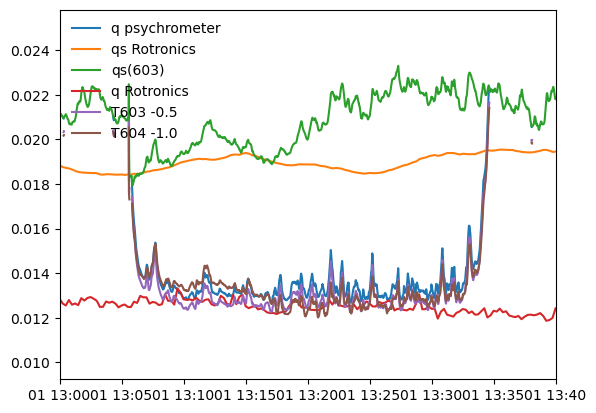

PyObject <matplotlib.legend.Legend object at 0x7fa210276950>

In [11]:

# plot q, qs calculations

nanmask(f, x) = f(x) ? x : NaN
# how do I broadcast it?

ii = t605.<t603_605
mask = zeros(size(ii))
mask[.!ii] .= NaN
plot(dtime605, mask.+q )
plot(dtime605, qs_rot_605) # mask.+qw)
plot(dtime605, qw)

plot( Date(1,1,1) .+ rot.Time + Second(60*7.5) , rot_q )
# tw = Twet(t603_605, q, p0)
plot(dtime605, mask.+qtest)
plot(dtime605, mask.+qtest604)

xlim([DateTime(1,1,1,13,0,0), DateTime(1,1,1,13,40,0)])
X = ax.xaxis
mdates = PyPlot.matplotlib.dates
X.set_major_locator(mdates.MinuteLocator(10))
X.set_major_formatter(mdates.DateFormatter("%H:%M")) # Specify the format - %b gives us Jan, Feb...
legend(["q psychrometer", "qs Rotronics", "qs(603)", "q Rotronics",
        "T603 -0.5", "T604 -1.0"]; frameon=false)

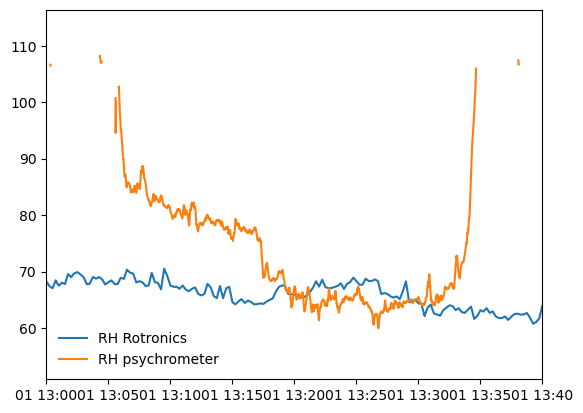

PyObject <matplotlib.legend.Legend object at 0x7fa24113afd0>

In [12]:
# relative humidity
subplot(1,1,1)

plot(dtime605, 100q_rot_605./qs_rot_605)
plot(dtime605, mask.+100q./qs604)

xlim([DateTime(1,1,1,13,0,0), DateTime(1,1,1,13,40,0)])
X = ax.xaxis
mdates = PyPlot.matplotlib.dates
X.set_major_locator(mdates.MinuteLocator(10))
X.set_major_formatter(mdates.DateFormatter("%H:%M")) # Specify the format - %b gives us Jan, Feb...
legend(["RH Rotronics", "RH psychrometer"]; frameon=false)

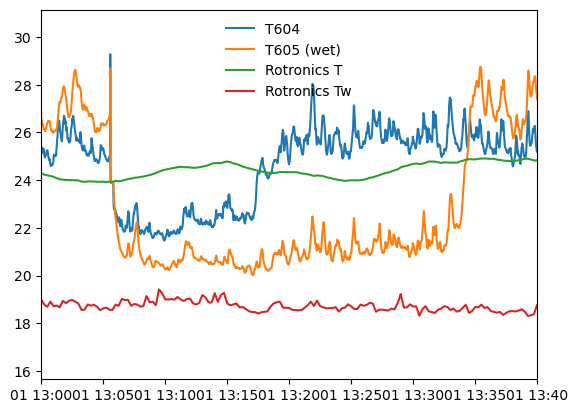

PyObject <matplotlib.legend.Legend object at 0x7fa26298c710>

In [13]:
# plot T, Tw from 604-605 thermistor calculations
# compared to T, Tw from Rotronics
subplot(1,1,1)
plot(dtime605, t604_605)
plot(dtime605, t605)
plot(dtime605, t_rot_605 )
plot(dtime605, tw_rot_605 )

xlim([DateTime(1,1,1,13,0,0), DateTime(1,1,1,13,40,0)])
X = ax.xaxis
mdates = PyPlot.matplotlib.dates
X.set_major_locator(mdates.MinuteLocator(10))
X.set_major_formatter(mdates.DateFormatter("%H:%M")) # Specify the format - %b gives us Jan, Feb...
legend(["T604", "T605 (wet)", "Rotronics T","Rotronics Tw"]; frameon=false)

Even troughs in T604, T605 (wet) during 13:15-13:30 are warmer than the T, Tw independently measured by Rotronics.